# Cryptocurrency Volatility Analysis
## Comparing volatility patterns across major cryptocurrencies

**Data Source:** CoinGecko API  
**Analysis Focus:** BTC, ETH, SOL, MATIC price volatility and risk metrics  
**Time Period:** Last 365 days  
**Leverage:** Your crypto trading background for deeper insights

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import requests
import time

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [2]:
# CoinGecko API credentials
COINGECKO_API_KEY = 'CG-koau7yikMyxe654ntiaukUAs'

# Cryptocurrencies to analyze (CoinGecko IDs)
crypto_ids = {
    'bitcoin': 'BTC',
    'ethereum': 'ETH',
    'solana': 'SOL',
    'matic-network': 'MATIC'
}

# Time range
days = 365
print(f"Fetching {days} days of cryptocurrency data")

Fetching 365 days of cryptocurrency data


In [3]:
# Function to fetch crypto data from CoinGecko
def fetch_crypto_data(coin_id, days, api_key):
    """
    Fetch historical crypto data from CoinGecko
    """
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': days,
        'interval': 'daily'
    }
    headers = {
        'x-cg-demo-api-key': api_key
    }
    
    response = requests.get(url, params=params, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        
        # Extract prices
        prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
        prices['date'] = pd.to_datetime(prices['timestamp'], unit='ms')
        
        # Extract volumes
        volumes = pd.DataFrame(data['total_volumes'], columns=['timestamp', 'volume'])
        
        # Extract market caps
        market_caps = pd.DataFrame(data['market_caps'], columns=['timestamp', 'market_cap'])
        
        # Merge all data
        df = prices.copy()
        df['volume'] = volumes['volume'].values
        df['market_cap'] = market_caps['market_cap'].values
        df['coin'] = crypto_ids[coin_id]
        
        return df[['date', 'coin', 'price', 'volume', 'market_cap']]
    
    return None

# Fetch data for all cryptocurrencies
all_crypto_data = []
for coin_id, symbol in crypto_ids.items():
    print(f"Fetching {symbol}...")
    df = fetch_crypto_data(coin_id, days, COINGECKO_API_KEY)
    if df is not None:
        all_crypto_data.append(df)
        print(f"  ✓ Got {len(df)} days of data")
    time.sleep(1)  # Rate limiting

# Combine all data
crypto_data = pd.concat(all_crypto_data, ignore_index=True)
print(f"\nTotal records: {len(crypto_data)}")

Fetching BTC...


  ✓ Got 366 days of data


Fetching ETH...
  ✓ Got 366 days of data


Fetching SOL...
  ✓ Got 366 days of data


Fetching MATIC...
  ✓ Got 366 days of data



Total records: 1464


In [4]:
# Save raw data
crypto_data.to_csv('../data/raw/crypto_data.csv', index=False)
print("Data saved to data/raw/crypto_data.csv")

Data saved to data/raw/crypto_data.csv


In [5]:
# Basic data inspection
print("First few rows:")
print(crypto_data.head())
print("\nData info:")
print(crypto_data.info())
print("\nBasic statistics:")
print(crypto_data.describe())

First few rows:
        date coin         price        volume    market_cap
0 2024-10-03  BTC  60655.559792  4.187073e+10  1.198652e+12
1 2024-10-04  BTC  60727.863952  3.771114e+10  1.200491e+12
2 2024-10-05  BTC  62103.010473  3.034906e+10  1.226663e+12
3 2024-10-06  BTC  62091.932585  1.109545e+10  1.226762e+12
4 2024-10-07  BTC  62811.799728  1.459242e+10  1.241834e+12

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1464 non-null   datetime64[ns]
 1   coin        1464 non-null   object        
 2   price       1464 non-null   float64       
 3   volume      1464 non-null   float64       
 4   market_cap  1464 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 57.3+ KB
None

Basic statistics:
                                date          price        volume  \
count

In [6]:
# Calculate daily returns and volatility metrics
crypto_data['daily_return'] = crypto_data.groupby('coin')['price'].pct_change()

# Calculate rolling volatility (30-day window)
crypto_data['volatility_30d'] = crypto_data.groupby('coin')['daily_return'].transform(
    lambda x: x.rolling(window=30).std() * np.sqrt(365) * 100  # Annualized volatility %
)

# Calculate rolling Sharpe ratio (simplified, assuming 0% risk-free rate)
crypto_data['sharpe_30d'] = crypto_data.groupby('coin')['daily_return'].transform(
    lambda x: x.rolling(window=30).mean() / x.rolling(window=30).std() * np.sqrt(365)
)

print("Volatility metrics calculated")
print(crypto_data[['coin', 'date', 'price', 'daily_return', 'volatility_30d']].tail(10))

Volatility metrics calculated
       coin                date     price  daily_return  volatility_30d
1454  MATIC 2025-09-24 00:00:00  0.225057     -0.009421       73.849159
1455  MATIC 2025-09-25 00:00:00  0.224403     -0.002907       68.622371
1456  MATIC 2025-09-26 00:00:00  0.215904     -0.037873       67.356971
1457  MATIC 2025-09-27 00:00:00  0.220581      0.021661       67.728941
1458  MATIC 2025-09-28 00:00:00  0.222607      0.009186       66.714585
1459  MATIC 2025-09-29 00:00:00  0.228157      0.024933       66.714344
1460  MATIC 2025-09-30 00:00:00  0.226532     -0.007123       62.283969
1461  MATIC 2025-10-01 00:00:00  0.224311     -0.009806       53.900900
1462  MATIC 2025-10-02 00:00:00  0.238537      0.063423       58.815367
1463  MATIC 2025-10-02 01:37:59  0.238870      0.001395       52.902882


In [7]:
# Calculate summary statistics by coin
volatility_summary = crypto_data.groupby('coin').agg({
    'daily_return': ['mean', 'std', 'min', 'max'],
    'price': ['min', 'max']
}).round(4)

print("\nVolatility Summary by Cryptocurrency:")
print(volatility_summary)


Volatility Summary by Cryptocurrency:
      daily_return                               price             
              mean     std     min     max         min          max
coin                                                               
BTC         0.0021  0.0230 -0.0863  0.1015  60195.1807  123560.9936
ETH         0.0024  0.0391 -0.1466  0.2139   1471.3609    4829.2255
MATIC      -0.0002  0.0452 -0.1703  0.1536      0.1670       0.7162
SOL         0.0022  0.0446 -0.2001  0.2425    105.4865     262.5616


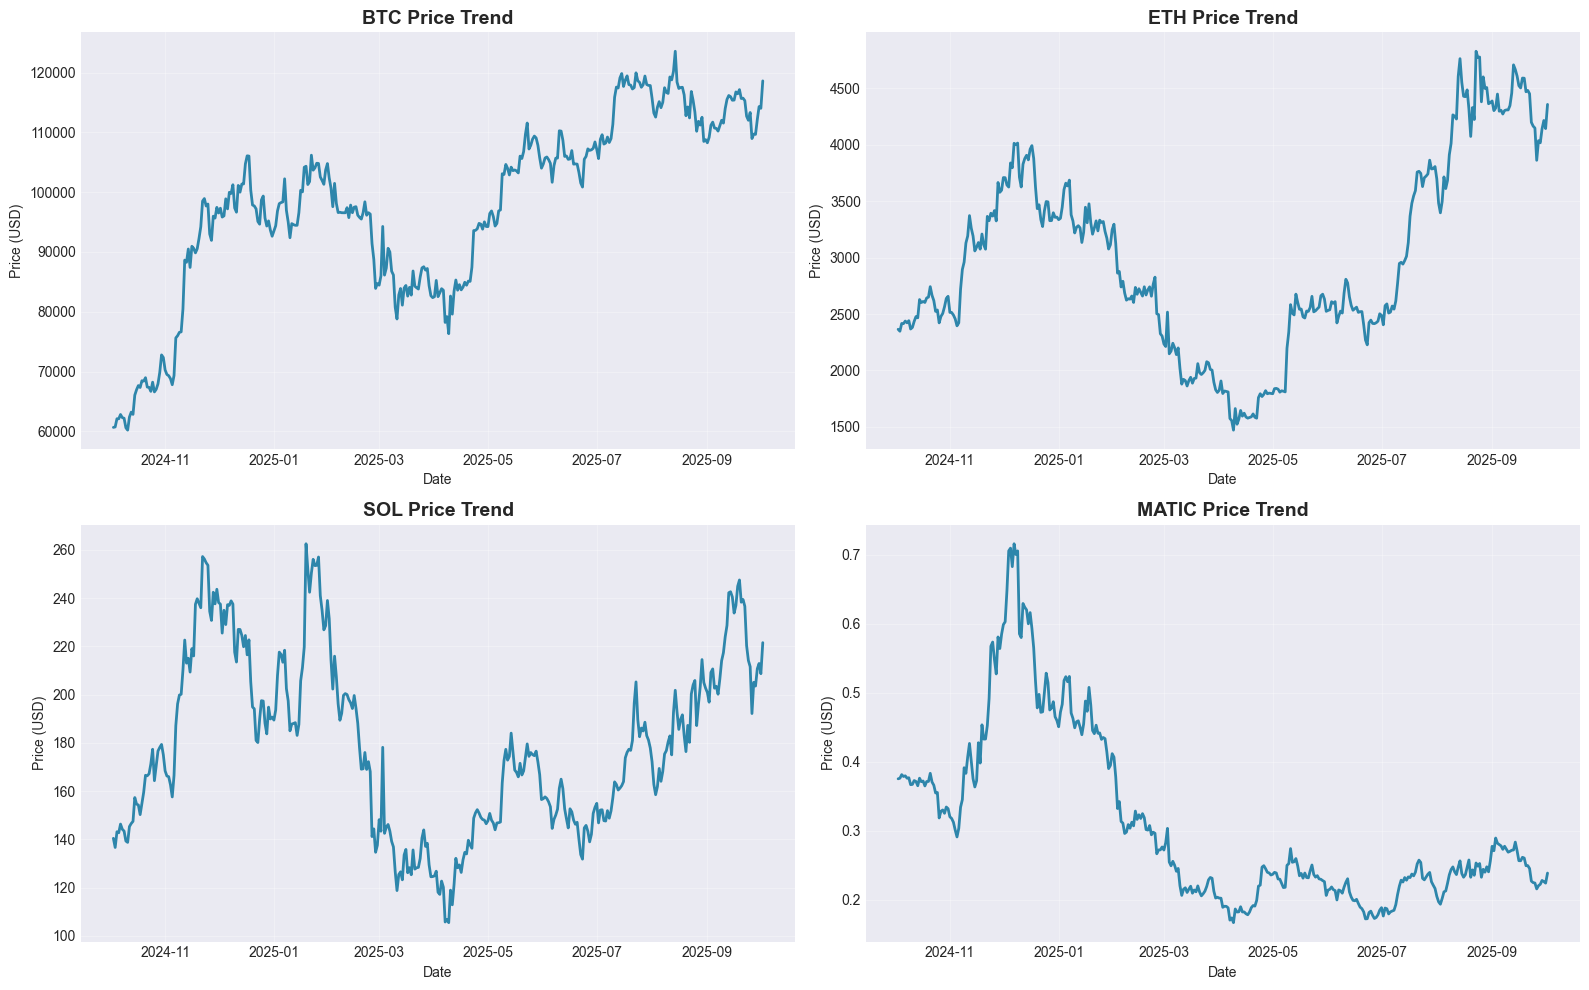

In [8]:
# Exploratory visualization: Price trends
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (coin_id, symbol) in enumerate(crypto_ids.items()):
    data = crypto_data[crypto_data['coin'] == symbol]
    axes[idx].plot(data['date'], data['price'], linewidth=2, color='#2E86AB')
    axes[idx].set_title(f'{symbol} Price Trend', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Price (USD)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/static/crypto_price_trends.png', dpi=300, bbox_inches='tight')
plt.show()

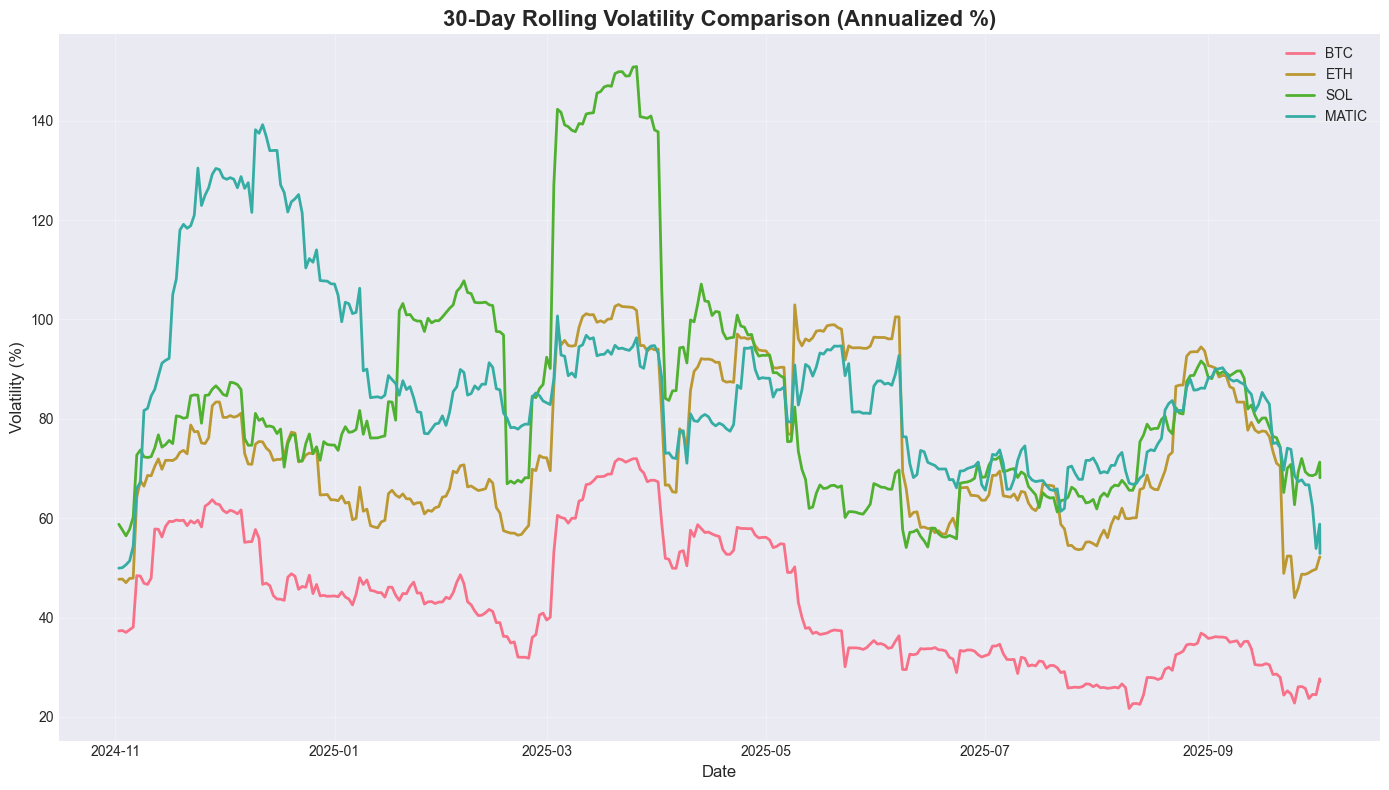

In [9]:
# Exploratory visualization: Volatility comparison
plt.figure(figsize=(14, 8))

for symbol in crypto_ids.values():
    data = crypto_data[crypto_data['coin'] == symbol].dropna()
    plt.plot(data['date'], data['volatility_30d'], label=symbol, linewidth=2)

plt.title('30-Day Rolling Volatility Comparison (Annualized %)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/static/crypto_volatility_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

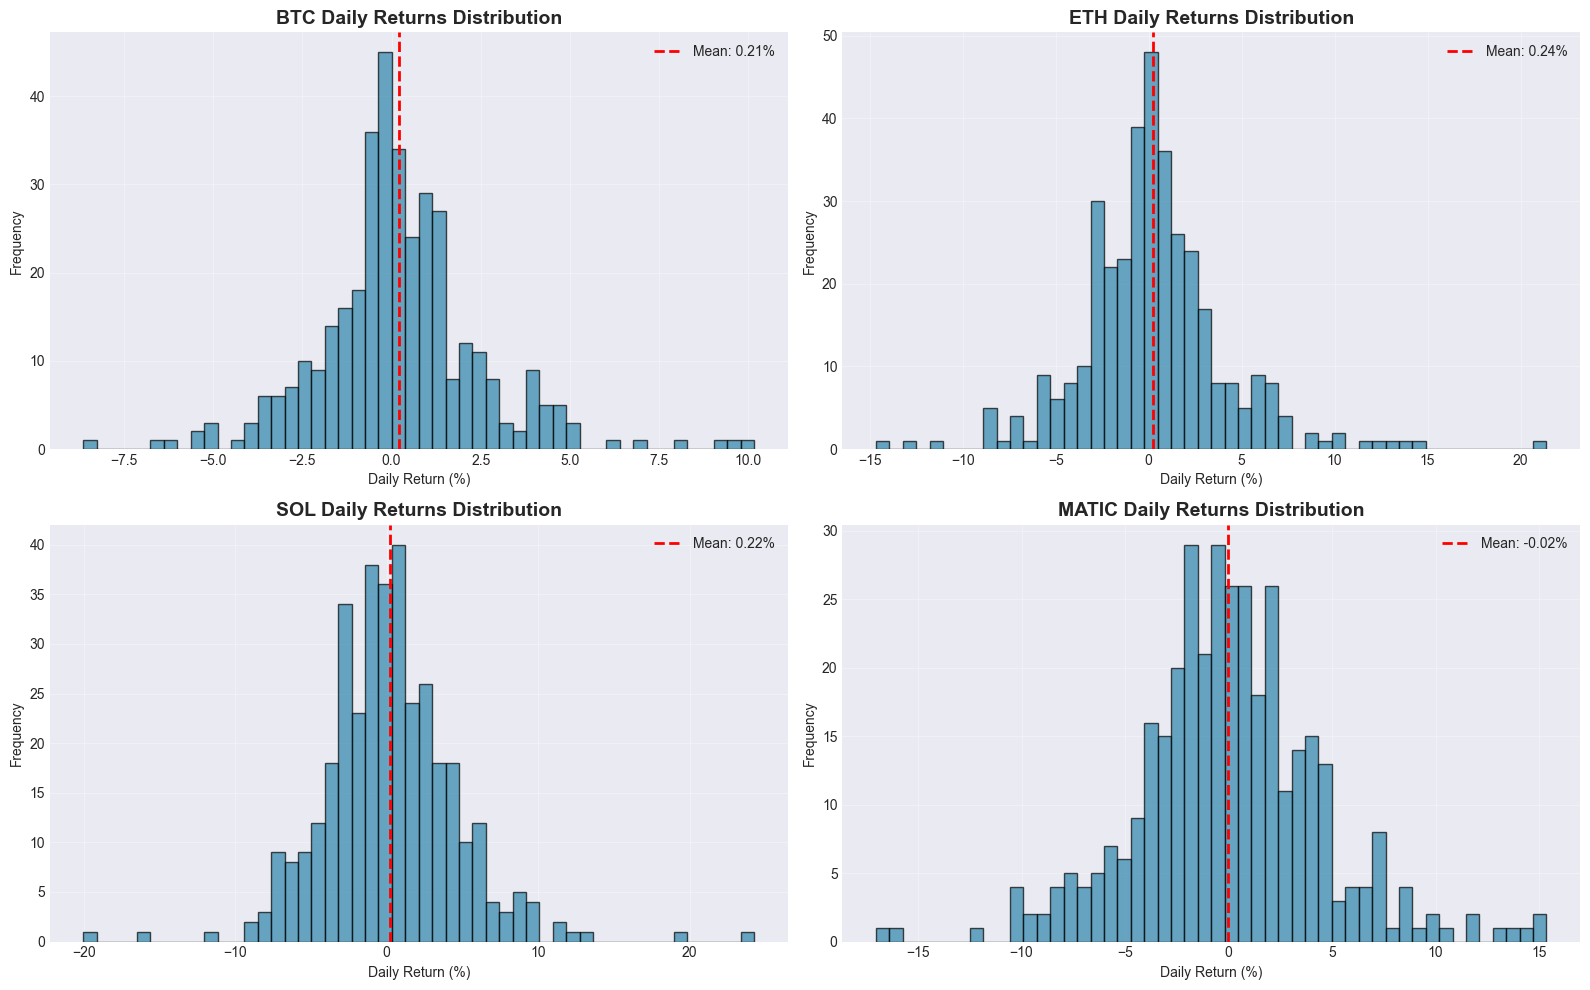

In [10]:
# Distribution of daily returns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, symbol in enumerate(crypto_ids.values()):
    data = crypto_data[crypto_data['coin'] == symbol]['daily_return'].dropna() * 100
    axes[idx].hist(data, bins=50, alpha=0.7, color='#2E86AB', edgecolor='black')
    axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}%')
    axes[idx].set_title(f'{symbol} Daily Returns Distribution', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Daily Return (%)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/static/crypto_returns_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

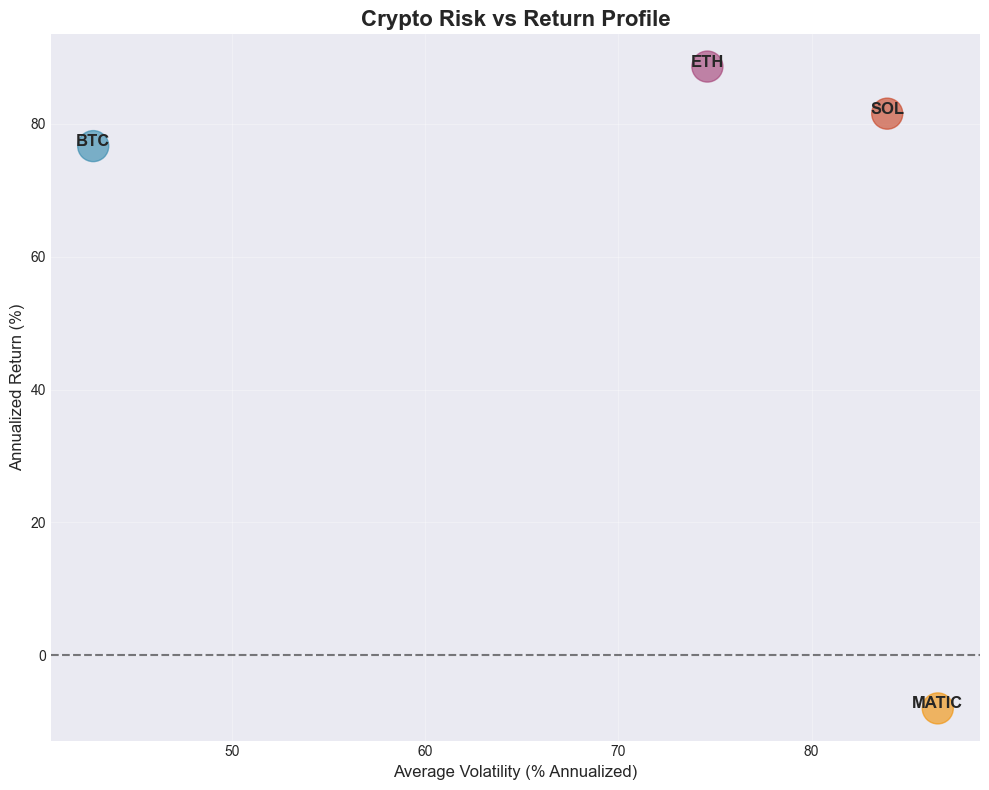

In [11]:
# Risk vs Return scatter plot
risk_return = crypto_data.groupby('coin').agg({
    'daily_return': lambda x: x.mean() * 365 * 100,  # Annualized return %
    'volatility_30d': 'mean'  # Average volatility
}).reset_index()

risk_return.columns = ['coin', 'annualized_return', 'avg_volatility']

plt.figure(figsize=(10, 8))
plt.scatter(risk_return['avg_volatility'], risk_return['annualized_return'], 
           s=500, alpha=0.6, c=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])

for idx, row in risk_return.iterrows():
    plt.annotate(row['coin'], (row['avg_volatility'], row['annualized_return']),
                fontsize=12, fontweight='bold', ha='center')

plt.title('Crypto Risk vs Return Profile', fontsize=16, fontweight='bold')
plt.xlabel('Average Volatility (% Annualized)', fontsize=12)
plt.ylabel('Annualized Return (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../visualizations/static/crypto_risk_return.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Save processed data
crypto_data.to_csv('../data/processed/crypto_processed.csv', index=False)
risk_return.to_csv('../data/processed/crypto_risk_return.csv', index=False)
print("Processed data saved!")

Processed data saved!


## Key Findings (To be updated after running analysis)

1. **Most Volatile Asset**: [To be filled]
2. **Best Risk-Adjusted Returns**: [To be filled]
3. **Correlation Insights**: [To be filled]

## Next Steps
- Create polished visualization highlighting volatility patterns
- Develop interactive Plotly charts for volatility comparison
- Analyze correlation with market events